<font color='2a6f97'>

# Actividad 1 Modelo Predictivo y Tratado de datos - Tips

</font>
Author: Diego Paredero Blanco

Version de python usada: 3.10.11

Hay bastante redundancia de datos dado que el ejemplo esta planteado como si se dividiese en varias notebooks en lugar de ir solo en uno, por lo que se van a encontrar bastantes df.copy en los cambios de secciones.


[Estadísticas y Predicciones](#estadisticas_y_predicciones)
1. [Carga de los datos](#carga_datos)
2. [Análisis Dataset](#analisisinicial)
3. [Tratado de datos null](#tratado_null)
    1. [Eliminación](#tratado_null_first)
    2. [Relleno](#tratado_null_second)
        1. [Tratado Total Bill](#tratado_null_second_total_bill) 
        2. [tratado_null_second_tip](#tratado_null_second_tip) 
        3. [tratado_null_second_smoke](#tratado_null_second_smoke) 

4. [Exploración de datos](#exploracion_datos)
    1. [Exploración de datos TIP](#exploracion_datos_tip)
        1. [Identificación Outliers y Observación Influencia](#identificacion_outliers)
        2. [Tratado Outliers](#tratado_outliers)
        3. [Estudio Size 2](#estudio_size2)

5. [Regresiones](#regresiones)
    1. [particionado y modelado](#particionado)
    2. [Predicción](#prediccion)
    3. [Calculo y obtención valores](#calculo_datos)
    4. [Nuevo tratamiento outliers](#outliers_modelado)
    5. [Nuevo modelado tras tratamiento](#modelado_2)
    6. [Random Forest](#random_forest)


In [1]:
# Comprobacion de que todas las librerias necesarias estan instaladas. En caso de fallo
# returar el > nul para ver el error. Actualmente esta para evitar saturar el output de la notebook
%pip install numpy > nul
%pip install matplotlib > nul
%pip install pandas > nul
%pip install spicy > nul
%pip install scikit-learn > nul
%pip install seaborn > nul

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importacion de librerias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import sklearn as sk
import random
from typing import Union

In [3]:
# Import de custom libraries
import lib.df_utils as df_utils
import lib.statistic_utils as statistic_utils

In [4]:
# Set default values for the notebool
plt.style.use('default')

--------------------------

<font color='ef476f'> 

## Estadísticas y Predicciones

</font>

<a id='estadisticas_y_predicciones'></a>
Datos proporcionados `tips.csv`

<div class="alert alert-block alert-warning">
<b>Aviso:</b> Aunque el dataset está relativamente limpio y libre de valores nulos, en este ejercicio se tratará como si contuviera dichos valores para ampliar el alcance y beneficio del mismo.
</div>

<a id='carga_datos'></a>
<font color='ffd166'> 

### Carga de los datos

</font>

Procederemos a cargar los datos con pandas.
<div class="alert alert-block alert-info">
<b>Extra:</b> Esto también es realizable con numpy, aunque por facilidad y comodidad usaremos pandas
</div>

In [5]:
# Ejemplo de carga con numpy

#data = np.genfromtxt('../data/tips.csv', delimiter=',', dtype=None, encoding='utf-8', skip_header=1)
#data[:5] 

#Carga de datos con pandas

df_original: pd.DataFrame = pd.read_csv('../data/tips.csv')
#Vamos a crear una copia del df original para no modificarlo hasta que sea necesario una vez ya tengamos
#una idea de como vamos a trabajar con los datos, que columnas vamos a necesitar y como vamos
#a limpiar los datos y rellenar los datos null
df: pd.DataFrame = df_original.copy()
#Visualizacion de los primeros 5 registros para comprobar que se ha cargado correctamente
df.head(5)


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


-------------------------

<a id='analisisinicial'></a>

<font color='ffd166'>

### Análisis Dataset

</font>

Examen inicial del dataset para identificar como proceder

In [6]:
df.describe(include='all')

,total_bill,tip,sex,smoker,day,time,size
count,244.000000,244.000000,244,244,244,244,244.000000
unique,NaN,NaN,2,2,4,2,NaN
top,NaN,NaN,Male,No,Sat,Dinner,NaN
freq,NaN,NaN,157,151,87,176,NaN
mean,19.785943,2.998279,NaN,NaN,NaN,NaN,2.569672
std,8.902412,1.383638,NaN,NaN,NaN,NaN,0.951100
min,3.070000,1.000000,NaN,NaN,NaN,NaN,1.000000
25%,13.347500,2.000000,NaN,NaN,NaN,NaN,2.000000
50%,17.795000,2.900000,NaN,NaN,NaN,NaN,2.000000
75%,24.127500,3.562500,NaN,NaN,NaN,NaN,3.000000


In [7]:
df.isnull().sum()

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

-------------------------

<a id='tratado_null'></a>
<a id='tratado_null'></a>

<font color='ffd166'>

### Tratado de datos null

</font>


_Recordaremos que el dataset ya está limpio, pero aun asi haremos un tratado de datos nulls para demostración en este ejercicio_

<a id='tratado_null_first'></a>

<font color='06d6a0'>

#### Primera aproximación: eliminación de filas null

</font>

En caso de que hubiese pocas filas con valores null y supusiesen un porcentaje reducido de los datos totales simplemente las eliminaríamos


In [8]:
# Eliminamos las filas con valores nulos
df_null: pd.DataFrame = df.dropna().copy()

<a id='tratado_null_second'></a>

<font color='06d6a0'> 

#### Segunda aproximacion: Relleno de los datos con valores aproximados segun sus valores categoricos o numericos

</font>


Esto lo podemos realizar dado que en este dataset no hay excesivas variables categóricas

Primero vamos a ver las correlaciones de las variables categóricas con las variables numéricas y asi poder identificar cuales usamos para este relleno de datos

Vamos a hacer la suposición de que tenemos múltiples valores null en:
1. "total_bill" - calculándolo a través de variables categóricas
    
    <div class="alert alert-block alert-danger">
    <b>Disclamer:</b> lo mas optimo seria usar TIP y SIZE para calcular la aproximación del total-bill, pero el uso de variables numéricas para el cálculo de datos lo hacemos en el siguiente ejemplo con el tip
    </div>
2. "tip" - calculándolo a traves de variables numéricas
3. "smoker" - calculándolo a traves de variables categóricas

Asi trabajaremos con variables numéricas null y variables categóricas null

<Axes: >

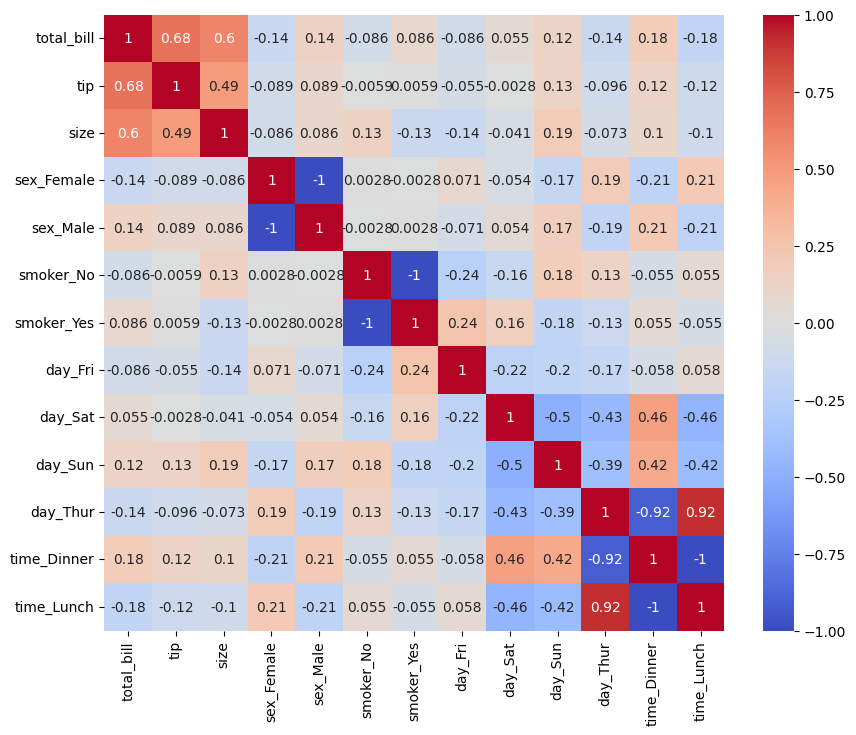

In [9]:
# Primero vamos a ver las correlaciones entre las variables
# Convertimos las variables categóricas en variables numéricas con get_dummies
df_encoded: pd.DataFrame = pd.get_dummies(df_null)

# Generamos la grafica de correlacion
correlation: pd.DataFrame = df_encoded.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

<a id='tratado_null_second_total_bill'></a>

<font color='118ab2'>

##### Comenzaremos con el relleno de los valores nulos en "total_bill"

</font>

Con la grafica anterior podemos diferenciar varias cosas:
1. La diferencia entre fumadores y no fumadores es prácticamente nula
2. La diferencia entre Hombres y mujeres si que puede llegarse a considerar en el relleno de datos ya que, de -0.14 a 0.14 tenemos una diferencia a considerar, no es exagerada, pero si interesante
3. En las diferencias entre si es comida o cena también hay una diferencia considerable


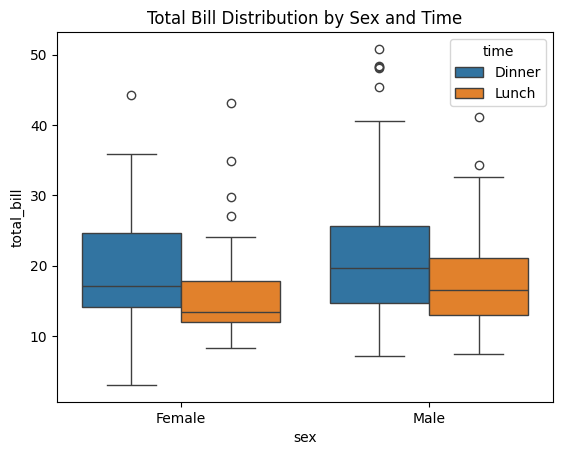

In [10]:
# Primero para confirmar haremos un boxplot de las variables sexo y total_bill y colorearemos por la variable time
sns.boxplot(x='sex', y='total_bill', hue='time', data=df_null)
plt.title('Total Bill Distribution by Sex and Time')
plt.show()

Tras el boxplot podemos asumir que si tiene un impacto destacable tanto el Time como el Sexo, asi mismo podemos ver que hay una buena cantidad de outliers por lo que debemos tener en cuenta a futuro de o bien normalizarlos o en lugar de usar la media usar la mediana

In [11]:
#Una vez visualizado generamos los 4 dataframes para sacar las medianas y rellenar los datos null
df_male: pd.DataFrame = df[df['sex'] == 'Male']
#Separacion entre smokers y non-smokers
df_male_dinner: pd.DataFrame = df_male[df_male['time'] == 'Dinner']
df_male_lunch: pd.DataFrame = df_male[df_male['time'] == 'Lunch']

#Para female
df_female: pd.DataFrame = df[df['sex'] == 'Female']
#Separacion entre smokers y non-smokers
df_female_dinner: pd.DataFrame = df_female[df_female['time'] == 'Dinner']
df_female_lunch: pd.DataFrame = df_female[df_female['time'] == 'Lunch']

df_male_dinner['total_bill'].describe()

count    124.000000
mean      21.461452
std        9.460974
min        7.250000
25%       14.705000
50%       19.630000
75%       25.642500
max       50.810000
Name: total_bill, dtype: float64

In [12]:
df_male_lunch['total_bill'].describe()

count    33.000000
mean     18.048485
std       7.953435
min       7.510000
25%      13.030000
50%      16.580000
75%      21.160000
max      41.190000
Name: total_bill, dtype: float64

In [13]:
df_female_dinner['total_bill'].describe()

count    52.000000
mean     19.213077
std       8.202085
min       3.070000
25%      14.080000
50%      17.190000
75%      24.692500
max      44.300000
Name: total_bill, dtype: float64

In [14]:
df_female_lunch['total_bill'].describe()

count    35.000000
mean     16.339143
std       7.500803
min       8.350000
25%      12.065000
50%      13.420000
75%      17.865000
max      43.110000
Name: total_bill, dtype: float64

In [15]:
# rellenamos los datos null con las medianas en el df original
# hacemos uso de el metodo loc para localizar los valores que cumplen las condiciones que necesitamos
# algo asi como un where en SQL o un if con multiples condiciones
# vamos a añadirle un pequeño ajuste para que no afecte a la moda sumandole el 1% del valor del tip en caso de que el tip no sea null
df.loc[(df['total_bill'].isnull()) & \
    (df['sex'] == 'Female') & \
    (df['time'] == 'Dinner'), 'total_bill'] = df_female_dinner['total_bill'].median() + 0.1 * df['tip']

df.loc[(df['total_bill'].isnull()) & \
    (df['sex'] == 'Female') & \
    (df['time'] == 'Lunch'), 'total_bill'] = df_female_lunch['total_bill'].median() + 0.1 * df['tip']

df.loc[(df['total_bill'].isnull()) & \
    (df['sex'] == 'Male') & \
    (df['time'] == 'Dinner'), 'total_bill'] = df_male_dinner['total_bill'].median() + 0.1 * df['tip']

df.loc[(df['total_bill'].isnull()) & \
    (df['sex'] == 'Male') & \
    (df['time'] == 'Lunch'), 'total_bill'] = df_male_lunch['total_bill'].median() + 0.1 * df['tip']

---------------

<a id='tratado_null_second_tip'></a>

<font color='118ab2'>

##### Comenzaremos con el relleno de los valores nulos en "TIP"

</font>

Ahora realizaremos un procedimiento similar al anterior dado que es otra variable numérica y identificaremos donde están las mayores correlaciones de los TIPs, en este caso usaremos la variable numérica ya tratada "total_bill"


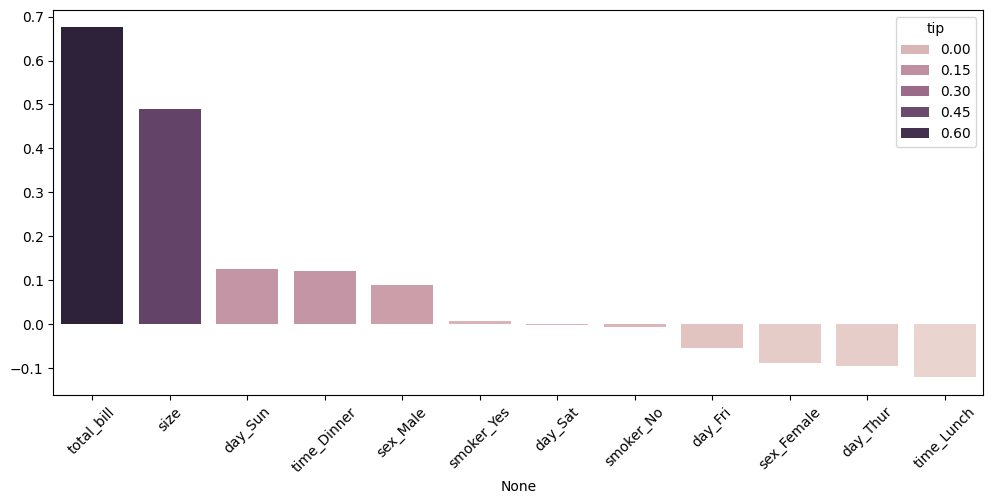

In [16]:
corr_price: pd.DataFrame = correlation['tip'] # filtrar correlación precio
corr_price = corr_price.sort_values(ascending=False)[1:] # ordenar descendente
plt.figure(figsize=(12, 5))
sns.barplot(x=corr_price.index, y=corr_price.values , hue=corr_price)
plt.xticks(rotation=45);

Podemos identificar claramente como el total_bill y el size tienen una fuerte correlación con el tip final, por lo que haremos un pequeño calculo para aproximar los valores null a algo real

Usaremos Bins (Para asi crear rangos de valores, en el caso de el totalbill que tiene más variación usaremos 10 rangos de valores, mientras que en el size usaremos solo 5)

In [17]:
# Para no usar regresion aqui dado que aun no es una parte que se haya visto en clase, usaremos bins par ahacer un calculo mas sencillo
# y no tener que hacer una regresion lineal

N_TOTAL_BILL_BINS: int = 10
N_SIZE_BINS: int = 5

# Group the data into bins and calculate the mean of the tips for each group
bins_total_bill: pd.Series = pd.cut(df_null['total_bill'], bins=N_TOTAL_BILL_BINS)
bins_size: pd.Series = pd.cut(df_null['size'], bins=N_SIZE_BINS)

# Combine the bins into a DataFrame to be able to calculate the mean
grouping: pd.DataFrame = pd.DataFrame({'total_bill_bin': bins_total_bill, 'size_bin': bins_size})

# Calculate the mean of the tips for each group
mean_tips: pd.Series = df_null.groupby([bins_total_bill, bins_size], observed=True)['tip'].mean()

# Define a function that imputes the tip in case it is null
def impute_tip(row: pd.Series) -> Union[float, pd.Series]:
    if pd.isna(row['tip']):
        total_bill_bin: pd.Series = pd.cut([row['total_bill']], bins=N_TOTAL_BILL_BINS)[0]
        size_bin: pd.Series = pd.cut([row['size']], bins=N_SIZE_BINS)[0]
        return mean_tips[total_bill_bin, size_bin]
    return row['tip']

# Launch the function against all the values to impute the null values, it does not affect the non-null ones
df_null['tip'] = df_null.apply(impute_tip, axis=1)

------------

<a id='tratado_null_second_smoke'></a>

<font color='118ab2'>

##### Comenzaremos con el relleno de los valores nulos en "SMOKE"

</font>

Primero sacamos las correlaciones de smoke para tenerlas de nuevo a mano y mas visibles

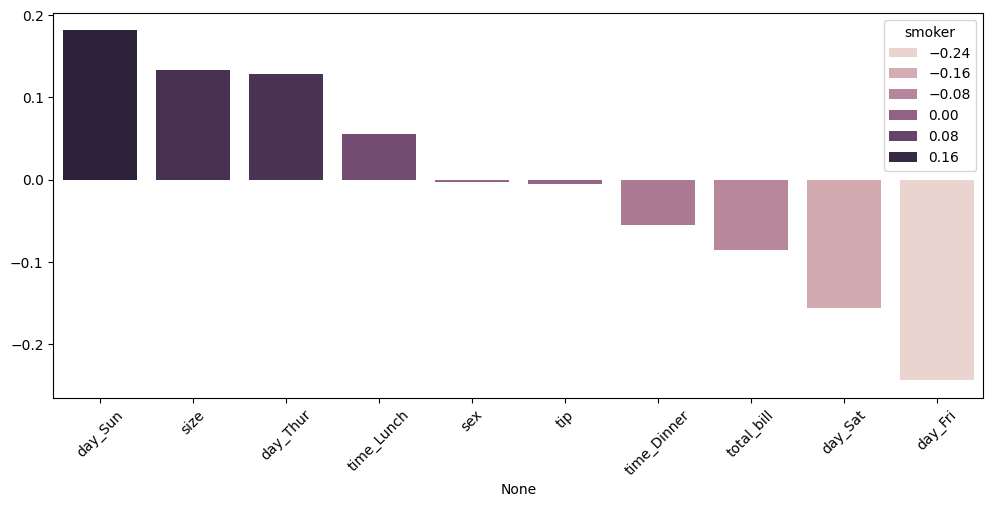

In [18]:
# Convert the categorical variable to a binary variable
df_smoke: pd.DataFrame = df_null.copy()
df_smoke['smoker'] = df_smoke['smoker'].map({'Yes': 0, 'No': 1})
df_smoke['sex'] = df_smoke['sex'].map({'Female': 0, 'Male': 1})
df_smoke_encoded: pd.DataFrame = pd.get_dummies(df_smoke)
# Compute the correlation matrix
correlation_smoker: pd.DataFrame = df_smoke_encoded.corr()
corr_smoker: pd.DataFrame = correlation_smoker['smoker'] # filtrar correlación precio
corr_smoker = corr_smoker.sort_values(ascending=False)[1:] # ordenar descendente
plt.figure(figsize=(12, 5))
sns.barplot(x=corr_smoker.index, y=corr_smoker.values , hue=corr_smoker)
plt.xticks(rotation=45);

Podemos ver que el que la persona sea o no fumadora no tiene mucha correlación, no llegando ninguna variable a 0.2 de correlación. Por lo que procederemos a rellenarlos de manera aleatoria con fumadores o no fumadores.

In [19]:
choices = ["Yes", "No"]

df_null["smoker"] = df_null["smoker"].apply(
        lambda x: random.choice(choices) if pd.isnull(x) else x
    )

-----

Con esto acabamos la parte del tratado de nulos **SIN REGRESION LINEAL** _mas adelante cuando tratemos las regresiones lineales haremos el tratado de nulos numéricos con una regresión para predecir valores más acertados_
Nos aseguraremos de que todos los nulls estén bien tratados:


In [20]:
df = df_null.copy()
df.isnull().sum()

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

------------


<a id='exploracion_datos'></a>

<font color='ffd166'> 

###  Exploración de datos 

</font>

Tras el correspondiente tratado de datos nulls comenzamos con la exploración de datos, en este caso centrándonos en los Tips y el valor total. 
lo primero volveremos a realizar: 

1. Describe: Para estudiar las diferentes variables del dataset
2. BoxPlox: Para identificar los outliers dentro de ambas variables e identificar como proceder con ellos


In [21]:
#Generacion de la tabla de correlaciones para trabajar con ella a futuro
df_copy = df.copy()
df_encoded: pd.DataFrame = pd.get_dummies(df_copy)

# Generamos la grafica de correlacion
correlation: pd.DataFrame = df_encoded.corr()

df.describe(include='all')

,total_bill,tip,sex,smoker,day,time,size
count,244.000000,244.000000,244,244,244,244,244.000000
unique,NaN,NaN,2,2,4,2,NaN
top,NaN,NaN,Male,No,Sat,Dinner,NaN
freq,NaN,NaN,157,151,87,176,NaN
mean,19.785943,2.998279,NaN,NaN,NaN,NaN,2.569672
std,8.902412,1.383638,NaN,NaN,NaN,NaN,0.951100
min,3.070000,1.000000,NaN,NaN,NaN,NaN,1.000000
25%,13.347500,2.000000,NaN,NaN,NaN,NaN,2.000000
50%,17.795000,2.900000,NaN,NaN,NaN,NaN,2.000000
75%,24.127500,3.562500,NaN,NaN,NaN,NaN,3.000000


<a id='exploracion_datos_tip'></a>

<font color='06d6a0'>

#### Exploración de datos de TIP

</font>



<div class="alert alert-block alert-danger">
    <b>Disclamer:</b> Esta primera parte no seria necesaria al estar en el mismo archivo, pero se hará ya que en el formato real este estudio estaría en un archivo diferente al tratado de los nulls
</div>

Mostraremos la correlación de tip con el resto de columnas. Para identificar cuáles son las que más influencia tienen


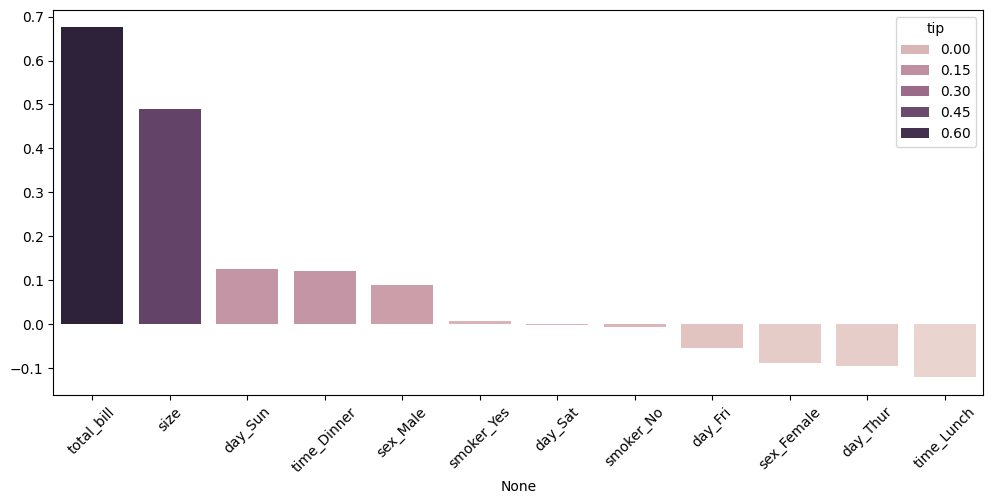

In [22]:
corr_price: pd.DataFrame = correlation['tip'] # filtrar correlación precio
#the 1: is to sort the values from the second one, since the first one is the tip itself
corr_price = corr_price.sort_values(ascending=False)[1:] # ordenar descendente
plt.figure(figsize=(12, 5))
sns.barplot(x=corr_price.index, y=corr_price.values , hue=corr_price)
plt.xticks(rotation=45);

<a id='identificacion_outliers'></a>

Se puede ver como claramente la mayor influencia sobre el tip son el size y el total_bill, por lo que vamos a explorar un boxplot de los 3, para identificar la influencia de los outliers y decidir cómo tratarlos

<font color='118ab2'> 

##### Identificación Outliers y Observación Influencia

</font>


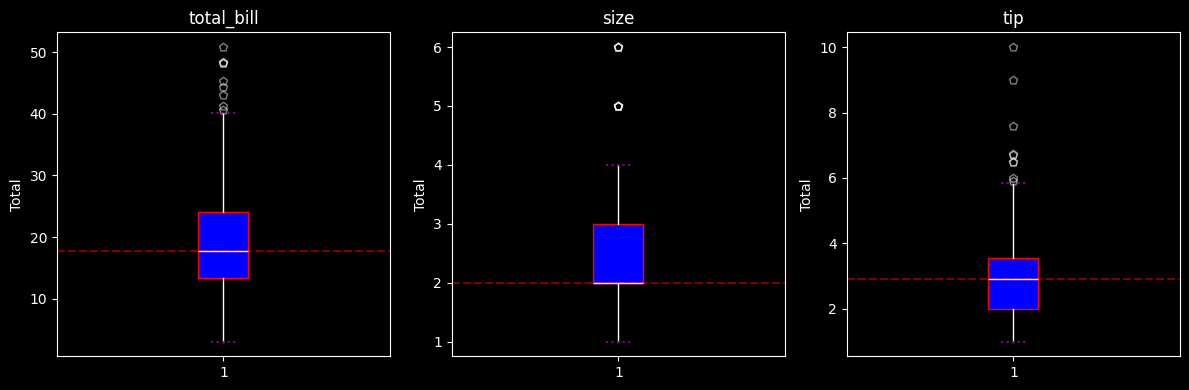

In [23]:
columns_to_plot: list[str] = ['total_bill', 'size', 'tip']
working_df: pd.DataFrame = df[columns_to_plot]

#to avoid superpose of past styles first set the default and then the one you want
plt.style.use('default')
plt.style.use('dark_background')

medians: pd.Series = df[columns_to_plot].median()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
boxplots: list[dict] = []

for i, column in enumerate(columns_to_plot):
    boxplot = axes[i].boxplot(df[column], patch_artist=True)
    boxplots.append(boxplot)
    axes[i].set_title(column)
    axes[i].axhline(y=medians.iloc[i], color='red', alpha=0.5,  linestyle='--')
    axes[i].add_patch

# Label for all axis
for ax in axes:
    ax.set_ylabel('Total')

# Custom boxplots
for boxplot in boxplots:
    for cap in boxplot['caps']:
        cap.set(color ='#8B008B', linewidth = 1.5, linestyle =":")
    
    #Custom outliers
    for flier in boxplot['fliers']:
        flier.set(marker =(5, 0),
                color ='#e7298a',
                alpha = 0.5)
    #Custom boxes
    for box in boxplot['boxes']:
        box.set(color="red")
        box.set_facecolor("blue")
# adjust the spacing
plt.tight_layout()
plt.show()
plt.style.use('default')

In [24]:
from lib.df_utils import get_outliers_multiple
#show how many outliers in each column
outliers = get_outliers_multiple(working_df, ['total_bill', 'size', 'tip'])
#show quantity of outliers for each column
outliers.count()

total_bill    21
size          21
tip           21
dtype: int64

<a id='tratado_outliers'></a>

<font color='118ab2'> 

##### Tratado de outliers

</font>

Dado que vemos que Total bill y Tip tienen mucha variedad de valores en los outliers vamos a explorarlos, además vamos a explorarlos en un scatterplot en el cual colorearemos los puntos según el size, para así ver la influencia de esos dos valores del size en los otros 2 campos


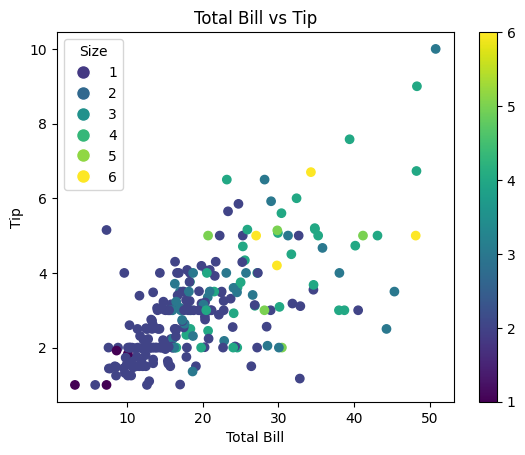

In [25]:

x = working_df['total_bill']
y = working_df['tip']
c = working_df['size']
unique_values = np.sort(c.unique())

scatter = plt.scatter(x, y, c=c, cmap='viridis')

cbar = plt.colorbar(scatter)
cbar.set_ticks(unique_values)
cbar.set_ticklabels(unique_values)

"""
legend_elements = []

# Loop over each unique value
for i in unique_values:
    # Create a Line2D object with specific properties:
    # - No line (empty data [0], [0])
    # - Circular marker ('o')
    # - White color for the marker edge ('w')
    # - Marker face color from the viridis colormap, normalized by the max value in unique_values
    # - Marker size 10
    legend_element = plt.Line2D(
        [0], [0],
        marker='o',
        color='w',
        markerfacecolor=plt.cm.viridis(i / max(unique_values)),
        markersize=10
    )
    # Add the created Line2D object to the legend elements list
    legend_elements.append(legend_element)
"""
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(i / max(unique_values)), markersize=10) for i in unique_values]
plt.legend(legend_elements, unique_values, title="Size")

plt.xlabel('Total Bill')
plt.ylabel('Tip')
plt.title('Total Bill vs Tip')

plt.show()

Una vez tenemos el scatter plot vamos a visualizar un scatter plot the los outliers en si, para que asi veamos como estan distribuidos estos

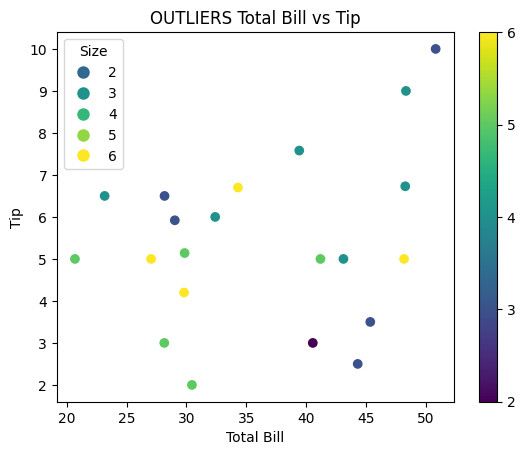

In [26]:
x = outliers['total_bill']
y = outliers['tip']
c = outliers['size']
unique_values = np.sort(c.unique())

scatter = plt.scatter(x, y, c=c, cmap='viridis')

cbar = plt.colorbar(scatter)
cbar.set_ticks(unique_values)
cbar.set_ticklabels(unique_values)

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(i / max(unique_values)), markersize=10) for i in unique_values]

plt.legend(legend_elements, unique_values, title="Size")

plt.xlabel('Total Bill')
plt.ylabel('Tip')
plt.title('OUTLIERS Total Bill vs Tip')

plt.show()

Se puede ver la gran influencia especialmente de los outliers de total bill sobre la variable tip, por lo que vamos a sacar el grafico eliminando estos outliers para ver como quedaría y ver si visualmente nos parece más apto para algún tipo de regresión.

Lo primero vamos a sacar unos outliers que no tengan en cuenta la columna size ya que vemos que el size no parece tener excesiva importancia en la influencia


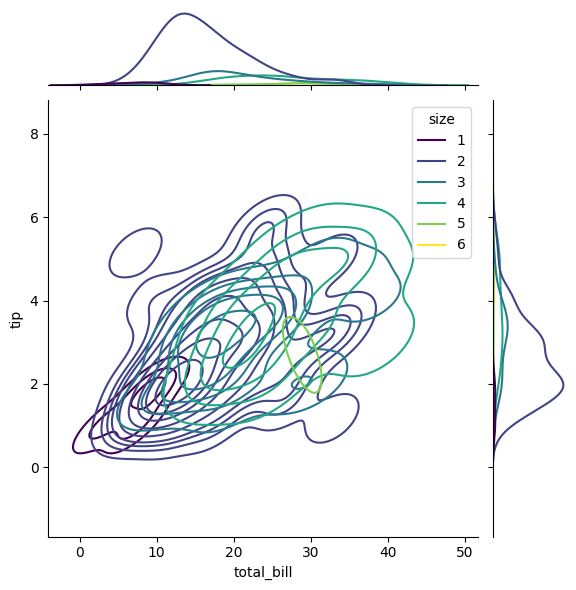

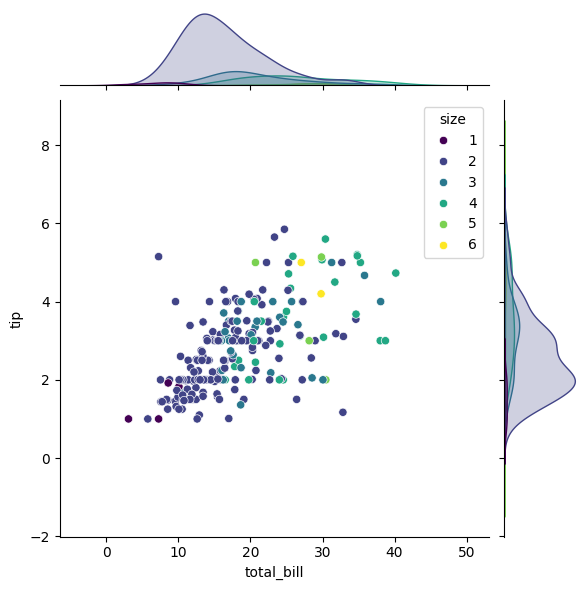

In [27]:

outliers: pd.DataFrame = get_outliers_multiple(working_df, ['total_bill', 'tip'])

working_df_without_outliers: pd.DataFrame = working_df.drop(outliers.index)
palette = sns.color_palette("viridis", as_cmap=True)
sns.jointplot(
    data=working_df_without_outliers,
    x='total_bill', y="tip", hue="size", palette=palette, kind="kde"
)
sns.jointplot(
    data=working_df_without_outliers,
    x='total_bill', y="tip", hue="size", palette=palette
)

Tras esto podemos ver que quitando algunas excepciones especialmente en el tamaño de mesa 2 la distribución parece tener una relación de Heterocedasticidad. Esto nos puede indicar que a mayor vaya siendo el total_bill mas dispersos van a estar los datos y por ende cualquier predicción será menos precisa. 

Siguientes pasos:
Estudiar porque los tamaños de mesa 2 tienen tan disperso el tip en ciertas situaciones (en caso de ser posible con los datos actuales)


<a id='estudio_size2'></a>

<font color='118ab2'> 

##### Estudio Size 2

</font>

In [28]:
#vamos a explorar los de size 2
working_df_size_2: pd.DataFrame = df[df['size'] == 2].copy()
#drop column size
working_df_size_2.drop(columns='size', inplace=True)
working_df_size_2.describe(include='all')

,total_bill,tip,sex,smoker,day,time
count,156.000000,156.000000,156,156,156,156
unique,NaN,NaN,2,2,4,2
top,NaN,NaN,Male,No,Sat,Dinner
freq,NaN,NaN,98,90,53,104
mean,16.448013,2.582308,NaN,NaN,NaN,NaN
std,6.043729,0.985501,NaN,NaN,NaN,NaN
min,5.750000,1.000000,NaN,NaN,NaN,NaN
25%,12.452500,2.000000,NaN,NaN,NaN,NaN
50%,15.370000,2.500000,NaN,NaN,NaN,NaN
75%,19.690000,3.145000,NaN,NaN,NaN,NaN


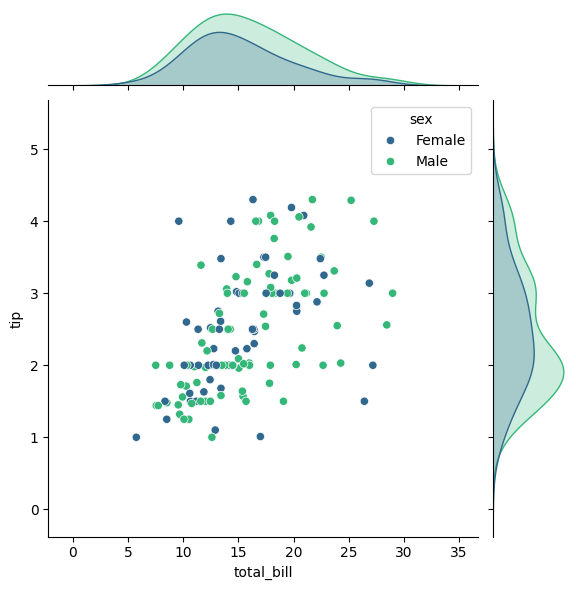

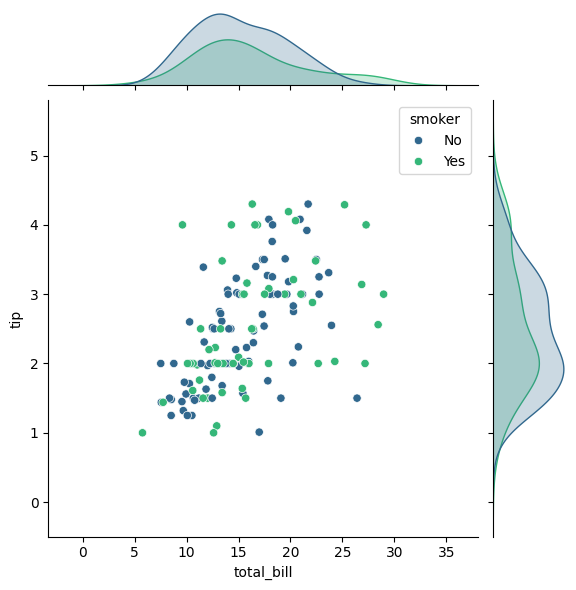

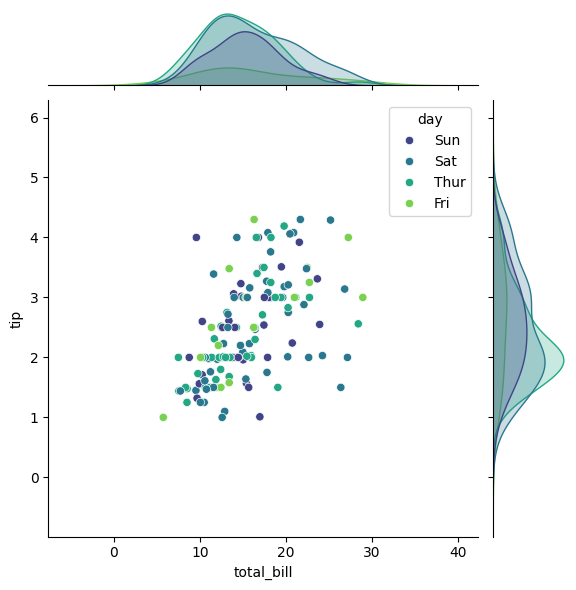

In [29]:
#lo primero vamos a sacar unos outliers que no tengan en cuenta la columna size ya que vemos que el size no parece tener excesiva importancia en la influencia
outliers: pd.DataFrame = get_outliers_multiple(working_df_size_2, ['total_bill', 'tip'])

working_df_size_2_wout_outliers: pd.DataFrame = working_df_size_2.drop(outliers.index)

g1 = sns.jointplot(
    data=working_df_size_2_wout_outliers,
    x='total_bill', y="tip", hue="sex", palette="viridis"
)

g2 = sns.jointplot(
    data=working_df_size_2_wout_outliers,
    x='total_bill', y="tip", hue="smoker", palette="viridis"
)

g3 = sns.jointplot(
    data=working_df_size_2_wout_outliers,
    x='total_bill', y="tip", hue="day", palette="viridis"
)


#get all the rows in df that are on working_df_without_outliers
df_without_outliers: pd.DataFrame = df[df.index.isin(working_df_without_outliers.index)]


Podemos ver como realmente no parece haber una diferencia considerable según el día/sexo/fumador por lo que no continuaremos con estas observaciones, y que al no ser algo claramente visual nos será más fácil interpretarlo una vez comenzadas las regresiones.

<a id='regresiones'></a>

<font color='ef476f'> 

## COMENZAMOS CON LAS REGRESIONES

</font>

Vamos a explorar como se comportaría la predicción del Tip en los diferentes dataset que hemos creado.
1. Con el dataset sin los nulos 
2. Con el dataset sin los nulos sin outliers

Compararemos cómo influye la presencia de los outliers en el dataset

In [30]:
df_train = df_null.copy()
df_train_no_outliers = df_without_outliers.copy()

#transform the categorical variables to binary
df_train = pd.get_dummies(df_train)
df_train_no_outliers = pd.get_dummies(df_train_no_outliers)

#en ambos casos queremos predecir el tip
y_df_train = df_train['tip']
y_df_train_no_outliers = df_train_no_outliers['tip']

X_df_train = df_train.drop(columns='tip')
X_df_train_no_outliers = df_train_no_outliers.drop(columns='tip')

df_train_no_outliers.head(15)

,total_bill,tip,size,sex_Female,sex_Male,smoker_No,smoker_Yes,day_Fri,day_Sat,day_Sun,day_Thur,time_Dinner,time_Lunch
0,16.99,1.01,2,True,False,True,False,False,False,True,False,True,False
1,10.34,1.66,3,False,True,True,False,False,False,True,False,True,False
2,21.01,3.50,3,False,True,True,False,False,False,True,False,True,False
3,23.68,3.31,2,False,True,True,False,False,False,True,False,True,False
4,24.59,3.61,4,True,False,True,False,False,False,True,False,True,False
5,25.29,4.71,4,False,True,True,False,False,False,True,False,True,False
6,8.77,2.00,2,False,True,True,False,False,False,True,False,True,False
7,26.88,3.12,4,False,True,True,False,False,False,True,False,True,False
8,15.04,1.96,2,False,True,True,False,False,False,True,False,True,False
9,14.78,3.23,2,False,True,True,False,False,False,True,False,True,False


<a id='particionado'></a>

<font color='ffd166'> 

### Particionado y modelado

</font>


In [31]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df_train, y_df_train, test_size=0.2, random_state=42)
X_train_df_no_outliers, X_test_df_no_outliers, y_train_df_no_outliers, y_test_df_no_outliers = train_test_split(X_df_train_no_outliers, y_df_train_no_outliers, test_size=0.2, random_state=42)

#train the model
model_df = LinearRegression()
model_df_no_outliers = LinearRegression()

model_df.fit(X_train_df, y_train_df)
model_df_no_outliers.fit(X_train_df_no_outliers, y_train_df_no_outliers)


LinearRegression()

<a id='prediccion'></a>

<font color='ffd166'> 

### Predictions

</font>

In [32]:
#predict the values
y_pred_df = model_df.predict(X_test_df)
y_pred_df_no_outliers = model_df_no_outliers.predict(X_test_df_no_outliers)

<a id='calculo_datos'></a>
<font color='06d6a0'> 

#### Calculo y obtencion valores

</font>

In [33]:
#calculate the mean squared error
mse_df = mean_squared_error(y_test_df, y_pred_df)
mse_df_no_outliers = mean_squared_error(y_test_df_no_outliers, y_pred_df_no_outliers)

mse_df, mse_df_no_outliers

(0.7033566017436107, 0.7154076192663683)

In [34]:
# calculate the r2 score
r2_df = r2_score(y_test_df, y_pred_df)
r2_df_no_outliers = r2_score(y_test_df_no_outliers, y_pred_df_no_outliers)

r2_df, r2_df_no_outliers

(0.4373018194348247, 0.4354395456941951)

Como podemos ver el r2 score es bastante bajo en ambos casos, de hecho, es mas bajo en el dataset sin outliers que en el dataset que los tiene

In [35]:
# calculate the mean absolute error
mae_df = mean_absolute_error(y_test_df, y_pred_df)
mae_df_no_outliers = mean_absolute_error(y_test_df_no_outliers, y_pred_df_no_outliers)

mae_df, mae_df_no_outliers

(0.6671331480264895, 0.7029162430784573)

In [36]:
# residuals
residuals_df = y_test_df - y_pred_df
residuals_df_no_outliers = y_test_df_no_outliers - y_pred_df_no_outliers


In [37]:
residuals_df.mean(), residuals_df_no_outliers.mean()

(-0.23303964582947853, -0.026575171255153966)

In [38]:
X_test_df['residuals'] = residuals_df  
X_test_df_no_outliers['residuals'] = residuals_df_no_outliers
X_test_df['predicted_tip'] = y_pred_df
X_test_df_no_outliers['predicted_tip'] = y_pred_df_no_outliers
X_test_df['real_tip'] = y_test_df
X_test_df_no_outliers['real_tip'] = y_test_df_no_outliers


In [39]:
#print only predicted and real tip
X_test_df[['predicted_tip', 'real_tip']].head(10)

,predicted_tip,real_tip
24,2.914366,3.18
6,2.002926,2.00
153,3.964256,2.00
211,3.763808,5.16
198,2.148363,2.00
176,2.674234,2.00
192,3.639346,2.56
124,2.291472,2.52
9,2.572072,3.23
101,2.458512,3.00


In [40]:
X_test_df_no_outliers.head(10)

,total_bill,size,sex_Female,sex_Male,smoker_No,smoker_Yes,day_Fri,day_Sat,day_Sun,day_Thur,time_Dinner,time_Lunch,residuals,predicted_tip,real_tip
230,24.01,4,False,True,False,True,False,True,False,False,True,False,-1.299365,3.299365,2.00
69,15.01,2,False,True,False,True,False,True,False,False,True,False,-0.295938,2.385938,2.09
9,14.78,2,False,True,True,False,False,False,True,False,True,False,0.620525,2.609475,3.23
204,20.53,4,False,True,False,True,False,False,False,True,False,True,0.912329,3.087671,4.00
15,21.58,2,False,True,True,False,False,False,True,False,True,False,0.783372,3.136628,3.92
210,30.06,3,False,True,False,True,False,True,False,False,True,False,-1.660514,3.660514,2.00
26,13.37,2,False,True,True,False,False,True,False,False,True,False,-0.207858,2.207858,2.00
206,26.59,3,False,True,False,True,False,True,False,False,True,False,0.018489,3.391511,3.41
161,12.66,2,False,True,True,False,False,False,True,False,True,False,0.054873,2.445127,2.50
130,19.08,2,False,True,True,False,False,False,False,True,False,True,-1.208595,2.708595,1.50


Podemos ver como con el proceso que hemos seguido se están dando datos demasiado imprecisos, vamos a comenzar un nuevo tratamiento para ver si lo podemos solucionar.

Vamos a trabajar con el que no contiene outliers y a aumentar su tratado a ver si podemos sacar algo más en claro


<a id='outliers_modelado'></a>
<font color='06d6a0'> 

#### Nuevo tratamiento outliers

</font>

In [41]:
Q1 = df_train_no_outliers[['total_bill', 'tip']].quantile(0.25)
Q3 = df_train_no_outliers[['total_bill', 'tip']].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_total_bill = df_train_no_outliers[(df_train_no_outliers['total_bill'] >= lower_bound['total_bill']) & (df_train_no_outliers['total_bill'] <= upper_bound['total_bill'])]
filtered_tip = df_train_no_outliers[(df_train_no_outliers['tip'] >= lower_bound['tip']) & (df_train_no_outliers['tip'] <= upper_bound['tip'])]

print("Filtered Total Bill:", filtered_total_bill.describe())
print("Filtered Tip:", filtered_tip.describe())
print("Original:", df_train_no_outliers.describe())

Filtered Total Bill:        total_bill         tip        size
count  225.000000  225.000000  225.000000
mean    18.116533    2.790756    2.462222
std      6.743425    1.084105    0.865842
min      3.070000    1.000000    1.000000
25%     13.030000    2.000000    2.000000
50%     16.990000    2.610000    2.000000
75%     22.230000    3.500000    3.000000
max     35.830000    5.850000    6.000000
Filtered Tip:        total_bill         tip        size
count  228.000000  228.000000  228.000000
mean    18.449518    2.792982    2.486842
std      7.216762    1.068602    0.877924
min      3.070000    1.000000    1.000000
25%     13.105000    2.000000    2.000000
50%     17.165000    2.675000    2.000000
75%     22.535000    3.500000    3.000000
max     40.170000    5.650000    6.000000
Original:        total_bill         tip        size
count  229.000000  229.000000  229.000000
mean    18.476856    2.806332    2.484716
std      7.212792    1.085224    0.876588
min      3.070000    1.000000  

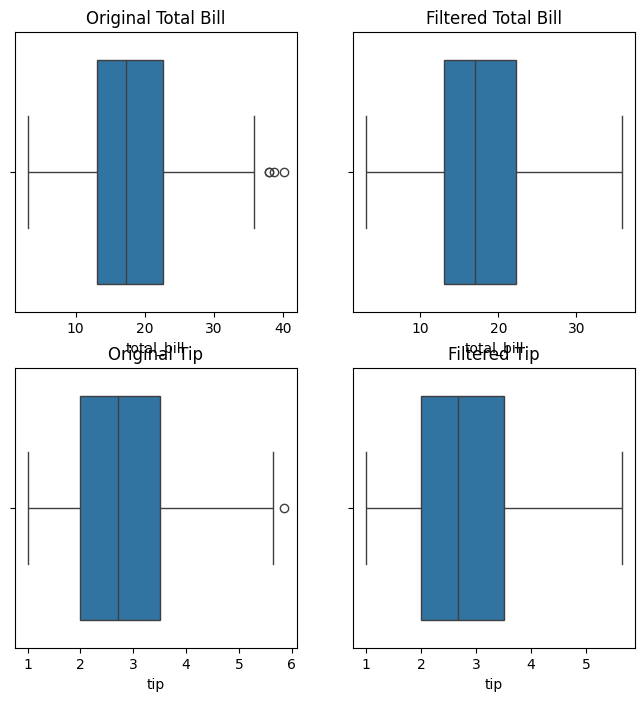

In [42]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

sns.boxplot(x=df_train_no_outliers['total_bill'], ax=axs[0, 0])
axs[0, 0].set_title('Original Total Bill')

sns.boxplot(x=filtered_total_bill['total_bill'], ax=axs[0, 1])
axs[0, 1].set_title('Filtered Total Bill')

sns.boxplot(x=df_train_no_outliers['tip'], ax=axs[1, 0])
axs[1, 0].set_title('Original Tip')

sns.boxplot(x=filtered_tip['tip'], ax=axs[1, 1])
axs[1, 1].set_title('Filtered Tip')

plt.show()

In [43]:
filtered_df = pd.merge(filtered_total_bill, filtered_tip, how='inner', on=list(filtered_total_bill.columns))

<a id='modelado_2'></a>
<font color='06d6a0'> 

#### Nuevo modelado tras tratamiento

</font>

Vamos a eliminar las columnas que no sean total_bill, size o tip en referencia al grafico de correlación hecho con anterioridad para comprobar si de esta manera los datos son más precisos


<font color='118ab2'> 

##### Linear regresion basica

</font>


In [44]:
#remove all columns except total_bill, tip and size
#filtered_df = filtered_df[['total_bill', 'tip', 'size']]
filtered_df.describe(include='all')

,total_bill,tip,size,sex_Female,sex_Male,smoker_No,smoker_Yes,day_Fri,day_Sat,day_Sun,day_Thur,time_Dinner,time_Lunch
count,226.000000,226.000000,226.000000,226,226,226,226,226,226,226,226,226,226
unique,NaN,NaN,NaN,2,2,2,2,2,2,2,2,2,2
top,NaN,NaN,NaN,False,True,True,False,False,False,False,False,True,False
freq,NaN,NaN,NaN,140,140,141,141,208,148,156,166,160,160
mean,18.042080,2.770221,2.460177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,6.730943,1.064706,0.864463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,3.070000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,13.000000,2.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,16.950000,2.580000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,22.015000,3.480000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
y_filtered_df = filtered_df['tip']
X_filtered_df = filtered_df.drop(columns='tip')

X_train_filtered_df, X_test_filtered_df, y_train_filtered_df, y_test_filtered_df = train_test_split(X_filtered_df, y_filtered_df, test_size=0.1, random_state=42)

model_filtered_df = LinearRegression()
model_filtered_df.fit(X_train_filtered_df, y_train_filtered_df)

y_pred_filtered_df = model_filtered_df.predict(X_test_filtered_df)

mse_filtered_df = mean_squared_error(y_test_filtered_df, y_pred_filtered_df)

r2_filtered_df = r2_score(y_test_filtered_df, y_pred_filtered_df)

mae_filtered_df = mean_absolute_error(y_test_filtered_df, y_pred_filtered_df)

residuals_filtered_df = y_test_filtered_df - y_pred_filtered_df

mse_filtered_df, r2_filtered_df, mae_filtered_df


(0.7645718063545344, 0.3052408501194034, 0.7246537601449764)

In [46]:
X_test_filtered_df['residuals'] = residuals_filtered_df  
X_test_filtered_df['predicted_tip'] = y_pred_filtered_df
X_test_filtered_df['real_tip'] = y_test_filtered_df

X_test_filtered_df.head(10)

,total_bill,size,sex_Female,sex_Male,smoker_No,smoker_Yes,day_Fri,day_Sat,day_Sun,day_Thur,time_Dinner,time_Lunch,residuals,predicted_tip,real_tip
9,14.78,2,False,True,True,False,False,False,True,False,True,False,0.724938,2.505062,3.23
184,13.51,2,False,True,False,True,False,False,False,True,False,True,-0.282004,2.282004,2.00
120,11.38,2,True,False,True,False,False,False,False,True,False,True,-0.097755,2.097755,2.00
207,13.42,2,False,True,False,True,True,False,False,False,False,True,-0.870906,2.450906,1.58
148,16.49,4,False,True,True,False,False,False,True,False,True,False,-1.042606,3.042606,2.00
215,11.61,2,False,True,True,False,False,True,False,False,True,False,1.455838,1.934162,3.39
182,13.00,2,True,False,False,True,False,False,False,True,False,True,-0.360195,2.360195,2.00
86,22.49,2,False,True,True,False,True,False,False,False,True,False,0.526628,2.973372,3.50
178,15.48,2,False,True,False,True,False,False,False,True,False,True,-0.414561,2.434561,2.02
175,15.69,2,False,True,False,True,False,False,True,False,True,False,-1.212519,2.712519,1.50


<font color='118ab2'> 

###### Exploracion del porque del posible fallo

</font>

<Axes: xlabel='total_bill', ylabel='tip'>

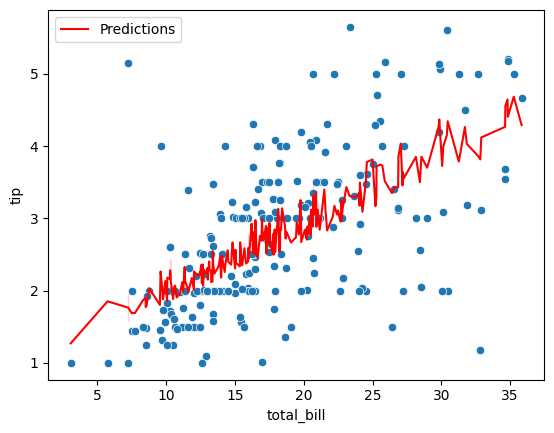

In [47]:
model = LinearRegression()
model.fit(X_filtered_df, y_filtered_df)
y_pred_model = model.predict(X_filtered_df)
sns.scatterplot(data=filtered_df, x='total_bill', y=filtered_df['tip'])
sns.lineplot(x=filtered_df['total_bill'], y=y_pred_model, color='r', label='Predictions')

<font color='118ab2'> 

###### Exploracion residuales 

</font>

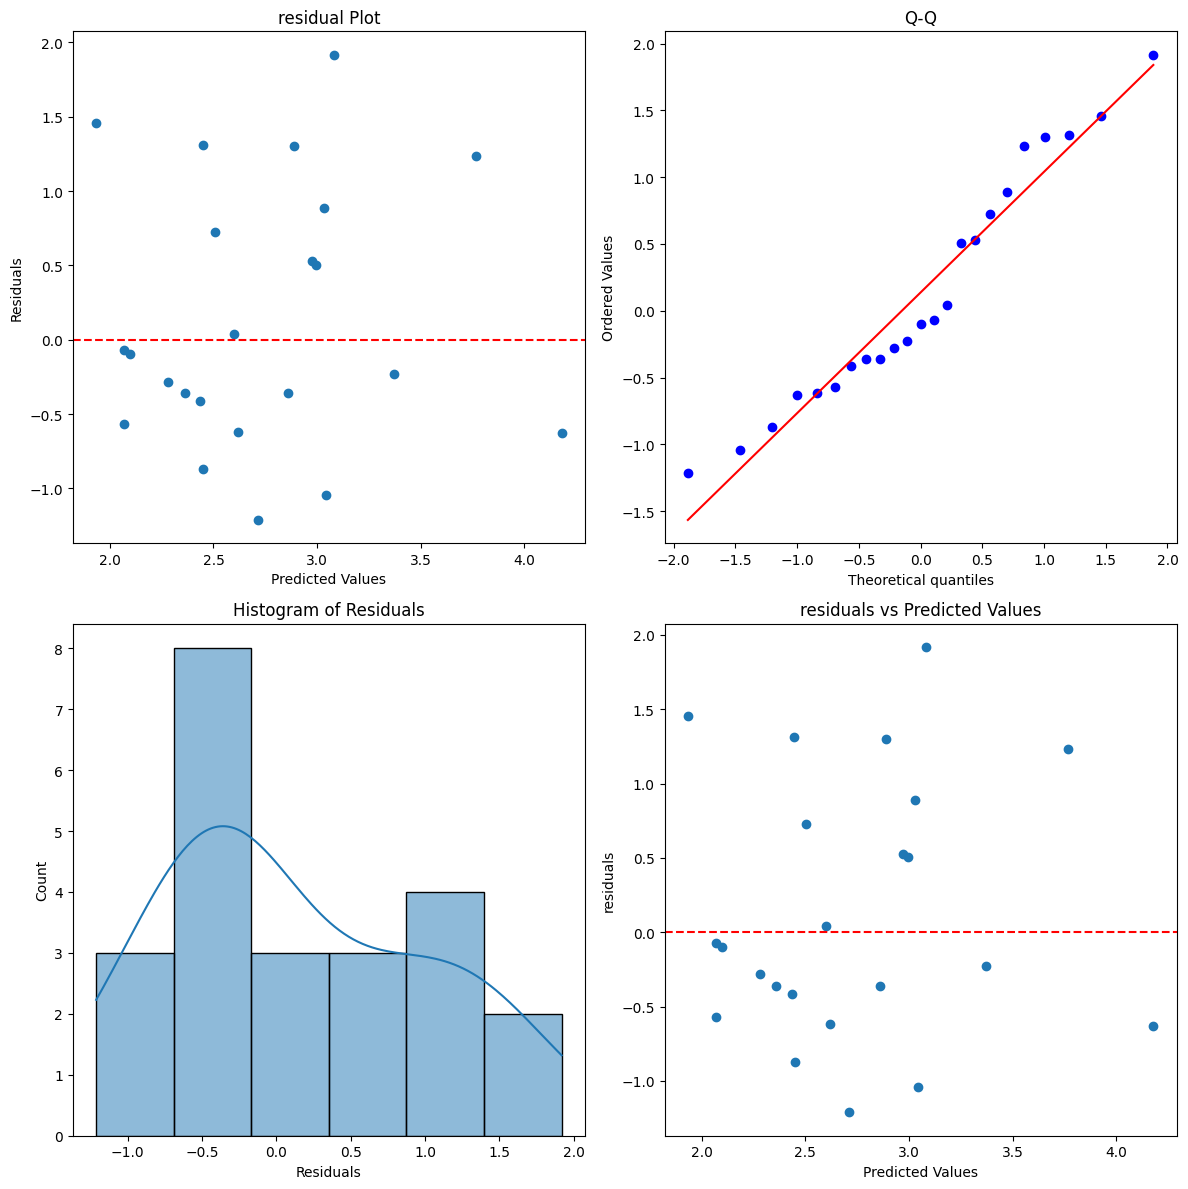

In [48]:
residuals = X_test_filtered_df['residuals']
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

#Residual Plot
axs[0, 0].scatter(y_pred_filtered_df, residuals)
axs[0, 0].axhline(y=0, color='r', linestyle='--')
axs[0, 0].set_xlabel('Predicted Values')
axs[0, 0].set_ylabel('Residuals')
axs[0, 0].set_title('residual Plot')

# Histo
sns.histplot(residuals, kde=True, ax=axs[1, 0])
axs[1, 0].set_xlabel('Residuals')
axs[1, 0].set_title('Histogram of Residuals')

# Q-Q 
stats.probplot(residuals, dist="norm", plot=axs[0, 1])
axs[0, 1].set_title('Q-Q')

#Heteroscedasticity 
axs[1, 1].scatter(y_pred_filtered_df, residuals)
axs[1, 1].axhline(y=0, color='r', linestyle='--')
axs[1, 1].set_xlabel('Predicted Values')
axs[1, 1].set_ylabel('residuals')
axs[1, 1].set_title('residuals vs Predicted Values')

plt.tight_layout()
plt.show()

<font color='118ab2'> 

##### Polinomial Regresion

</font>

In [49]:
from sklearn.preprocessing import PolynomialFeatures
preprocessor = PolynomialFeatures(degree=3)
X_g2 = preprocessor.fit_transform(X_filtered_df)

<Axes: xlabel='total_bill', ylabel='tip'>

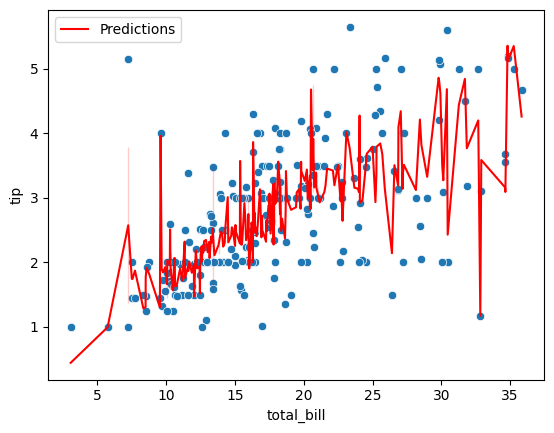

In [50]:
model = LinearRegression()
model.fit(X_g2, y_filtered_df)
y_pred = model.predict(X_g2)
sns.scatterplot(data=filtered_df, x='total_bill', y=filtered_df['tip'])
sns.lineplot(x=filtered_df['total_bill'], y=y_pred, color='r', label='Predictions')

Tras revisitar el tratado de outliers vemos que seguimos teniendo demasiadas diferencias, vamos a probar otros modelos de regresión a ver si se ajustan mas a nuestro problema.

Vamos a probar con un random-forest


<a id='random_forest'></a>
<font color='06d6a0'> 

##### Random Forest

</font>

Vamos a eliminar las columnas que no sean total_bill, size o tip en referencia al grafico de correlación hecho con anterioridad para comprobar si de esta manera los datos son más reales


In [51]:
from sklearn.ensemble import RandomForestRegressor
X_train, X_test, y_train, y_test = train_test_split(X_filtered_df, y_filtered_df, test_size=0.1, random_state=42)

random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

y_pred = random_forest_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
residuals = y_test - y_pred

cross_val_scores = cross_val_score(random_forest_model, X_filtered_df, y_filtered_df, cv=5, scoring='neg_mean_squared_error')
print("Cross-Validation MSE:", np.mean(-cross_val_scores))

X_test['residuals'] = residuals  
X_test['predicted_tip'] = y_pred
X_test['real_tip'] = y_test

X_test.head(10)


Cross-Validation MSE: 0.8735920163797107


,total_bill,size,sex_Female,sex_Male,smoker_No,smoker_Yes,day_Fri,day_Sat,day_Sun,day_Thur,time_Dinner,time_Lunch,residuals,predicted_tip,real_tip
9,14.78,2,False,True,True,False,False,False,True,False,True,False,0.8086,2.4214,3.23
184,13.51,2,False,True,False,True,False,False,False,True,False,True,-0.1765,2.1765,2.00
120,11.38,2,True,False,True,False,False,False,False,True,False,True,0.1378,1.8622,2.00
207,13.42,2,False,True,False,True,True,False,False,False,False,True,-1.3241,2.9041,1.58
148,16.49,4,False,True,True,False,False,False,True,False,True,False,-0.7694,2.7694,2.00
215,11.61,2,False,True,True,False,False,True,False,False,True,False,1.4928,1.8972,3.39
182,13.00,2,True,False,False,True,False,False,False,True,False,True,0.0039,1.9961,2.00
86,22.49,2,False,True,True,False,True,False,False,False,True,False,0.2232,3.2768,3.50
178,15.48,2,False,True,False,True,False,False,False,True,False,True,-0.2150,2.2350,2.02
175,15.69,2,False,True,False,True,False,False,True,False,True,False,-1.2489,2.7489,1.50


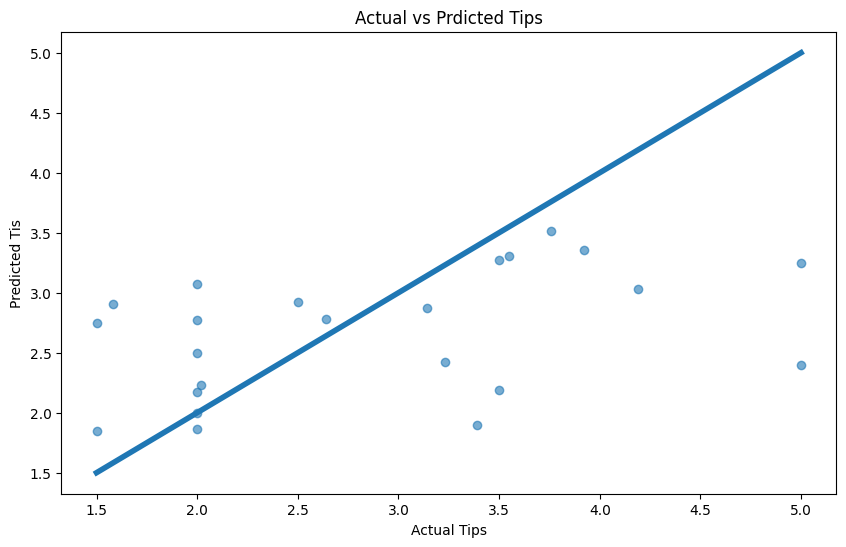

In [52]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], lw=4)
plt.xlabel('Actual Tips')
plt.ylabel('Predicted Tis')
plt.title('Actual vs Prdicted Tips')
plt.show()

<font color='118ab2'> 

##### Logaritmic Regresion


</font>

In [53]:
from sklearn.linear_model import Ridge
df_log = filtered_df.copy()

df_log['log_tip'] = np.log(df_log['tip'])
X = df_log.drop(columns=['tip', 'log_tip'])
y = df_log['log_tip']

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Create and train the Ridge regression model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

# Predict on the test set
y_pred_log = ridge_model.predict(X_test)

# Convert predictions back to original scale
y_pred = np.exp(y_pred_log)
y_test_orig = np.exp(y_test)

residuals = y_test_orig - y_pred



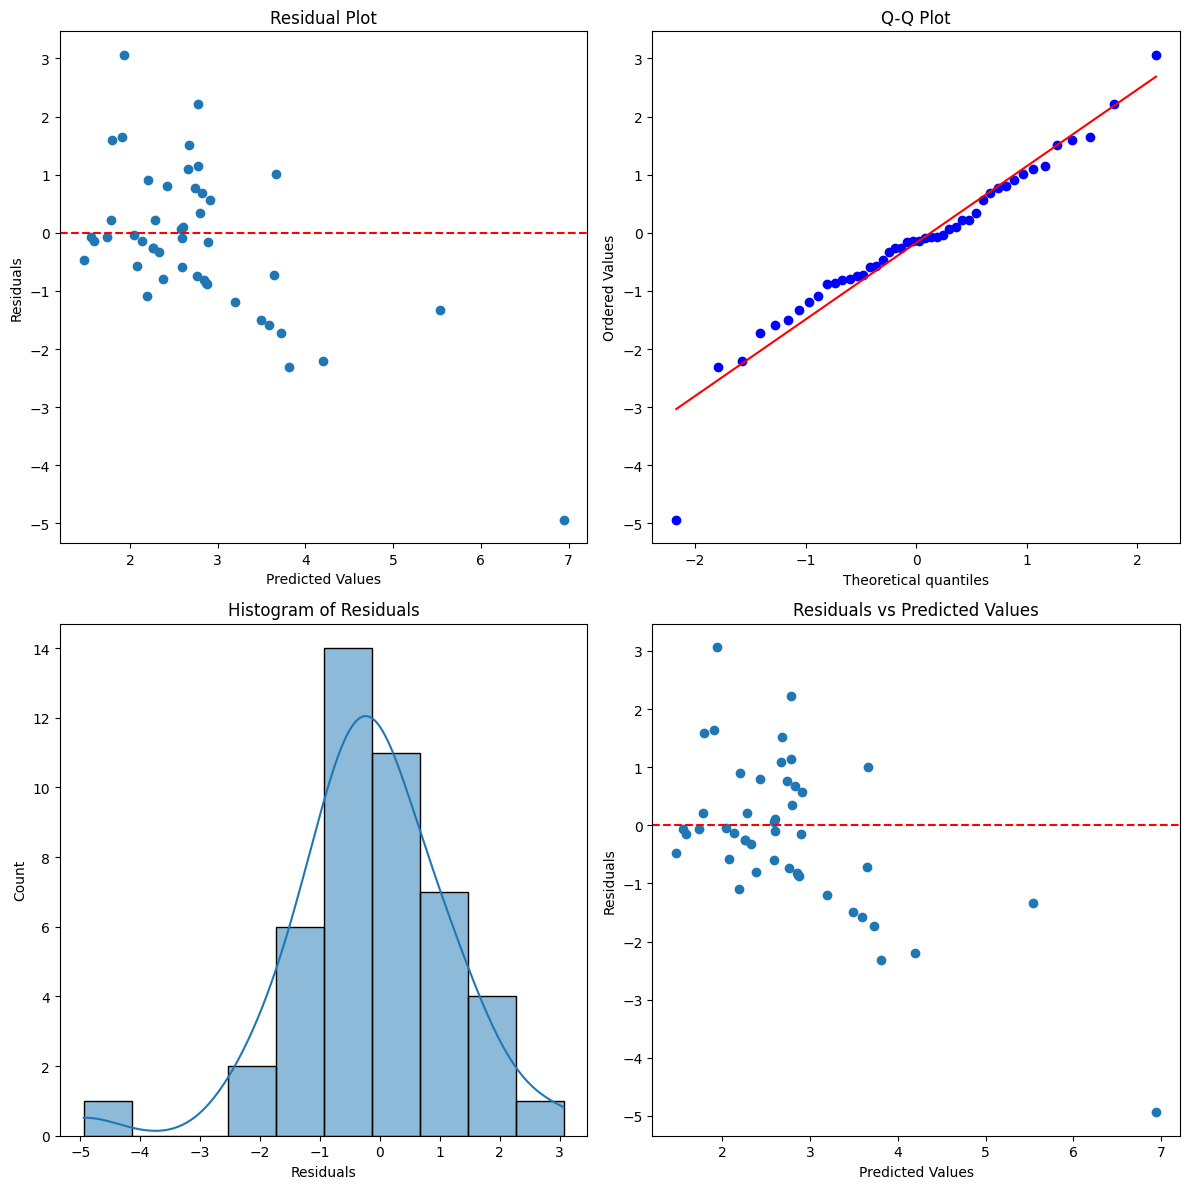

Mean Squared Error: 1.746053430492085
R-squared: -0.7164164505090866


In [54]:

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

axs[0, 0].scatter(y_pred, residuals)
axs[0, 0].axhline(y=0, color='r', linestyle='--')
axs[0, 0].set_xlabel('Predicted Values')
axs[0, 0].set_ylabel('Residuals')
axs[0, 0].set_title('Residual Plot')

sns.histplot(residuals, kde=True, ax=axs[1, 0])
axs[1, 0].set_xlabel('Residuals')
axs[1, 0].set_title('Histogram of Residuals')

stats.probplot(residuals, dist="norm", plot=axs[0, 1])
axs[0, 1].set_title('Q-Q Plot')

axs[1, 1].scatter(y_pred, residuals)
axs[1, 1].axhline(y=0, color='r', linestyle='--')
axs[1, 1].set_xlabel('Predicted Values')
axs[1, 1].set_ylabel('Residuals')
axs[1, 1].set_title('Residuals vs Predicted Values')

plt.tight_layout()
plt.show()
mse = mean_squared_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

In [55]:
test_results = pd.DataFrame({
    'Predicted Tip': y_pred,
    'Real Tip': y_test_orig,
    'Residuals': residuals
})

test_results.head(10)

,Predicted Tip,Real Tip,Residuals
9,2.425274,3.23,0.804726
184,2.590421,2.00,-0.590421
120,1.783674,2.00,0.216326
207,2.376737,1.58,-0.796737
148,2.861524,2.00,-0.861524
215,1.794835,3.39,1.595165
182,2.257981,2.00,-0.257981
86,2.822074,3.50,0.677926
178,2.759037,2.02,-0.739037
175,3.812734,1.50,-2.312734


Tras todas estas pruebas e intentos podemos zanjar en que con los conocimientos actuales y los datos disponibles no podemos hacer un modelo con una buena precisión.


Author: Diego Paredero Blanco